# Analysis of features in healthy controls

This notebook is used to creates the Supplementary Figure 1A and 1C

1- Analyse the covariate (sex, hemi, age) in the features using an OLS model

2- Correlation of surface-based thickness, curvature and gyrification extracted from our study’s healthy controls compared to the HCP cohort.

In [1]:
import nibabel as nb
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import ptitprince as pt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH


Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/models
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/params
Setting FS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/fs_outputs
Setting HIPPUNFOLD_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/hippunfold_outputs
Setting BIDS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/bids_outputs


 ## 1- Analyse covariate in controls combat features

In [2]:
hemis=['lh', 'rh']

#create cohort to smooth
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_avg.hdf5', dataset='dataset_C.csv')

#get feature list
features = cohort.full_feature_list

#get subjects 
subjects = cohort.get_subject_ids(group='control', lesional_only = False)
len(subjects)


121

In [44]:
base_features=[
    '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.hippunfold_volume',
    '.label-{}.thickness.sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    ]

base_features = ['.combat'+feature.format('avg') for feature in base_features]

features_title = {
                '.curvature' : 'mean\ncurvature',
                '.gauss-curv_filtered': 'intrinsic\ncurvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness',
                '.hippunfold_volume' :'volume',
}

def return_features_title(feature):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]


In [4]:
# extract combat features and demographic information per subject
               
ages = []

df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=subj.group
        values['hemi'] = hemi
        values['age_scan'], values['sex'], values['site']  = subj.get_demographic_features(["Age at preoperative", "Sex", "Site"])

        #get structural and intensity features
        for feature in base_features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass
            # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)

In [4]:
# load or save matrix
file = os.path.join(BASE_PATH,'data_saved','matrix_controls_combat_avg_231211.csv')   
# df.to_csv(file)
df=pd.read_csv(file)

In [6]:
df.head()

,Unnamed: 0,ID,group,hemi,age_scan,sex,site,.combat.label-avg.hippunfold_volume_icvcorr,.combat.label-avg.hippunfold_volume,.combat.label-avg.thickness.sm1,.combat.label-avg.gyrification.sm1,.combat.label-avg.curvature.sm1,.combat.label-avg.gauss-curv_filtered_sm1
0,0,MELDH29C0001,control,lh,37.0,0.0,H29,2275.3100,2294.1320,1.554598,2.492877,0.159278,0.035149
1,1,MELDH29C0001,control,rh,37.0,0.0,H29,2307.3982,2333.5403,1.506928,2.568919,0.165780,0.030800
2,2,MELDH29C0002,control,lh,46.0,1.0,H29,2148.2090,2140.7502,1.435308,2.578108,0.174912,0.026728
3,3,MELDH29C0002,control,rh,46.0,1.0,H29,2227.5815,2210.7935,1.455439,2.535539,0.177263,0.028631
4,4,MELDH29C0003,control,lh,40.0,1.0,H29,2213.7540,2185.4230,1.475703,2.514281,0.172115,0.031258


In [34]:
# compare change correction for ICV and not

volume_icvcorr = df[df['group']=='control']['.combat.label-avg.hippunfold_volume_icvcorr'].values
volume = df[df['group']=='control']['.combat.label-avg.hippunfold_volume'].values

diff = abs((volume - volume_icvcorr))/volume
print(diff.mean())
print(diff.std())

0.010380997312915268
0.008363056016835978


In [28]:
diff = (volume - volume_icvcorr)
diff[8]/volume[8]

0.007394471933197243

### Create OLS model and check covariate


In [45]:
# create a matrix to store coefficients and p-values of OLS model

base_features=[
    # '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.hippunfold_volume',
    '.label-{}.thickness.sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    ]

base_features = ['.combat'+feature.format('avg') for feature in base_features]


sub_features = base_features

variables=['age', 'sex', 'hemi']
# to combine in a matrix
matrix_coefs= np.zeros((len(sub_features),len(variables)))
matrix_pvals= np.zeros((len(sub_features),len(variables)))

In [46]:
#fitting models
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

features = base_features

subdf=df.copy()

data = pd.DataFrame()
data['age']=subdf['age_scan'].copy()
data['sex']=subdf['sex'].copy()
data['hemi']=subdf['hemi'].copy()
data['site']=subdf['site'].copy()

for i, feature in enumerate(features):
    print(feature)
    data['feature']=subdf[feature].copy()

    #describe model
    formula = 'feature ~  age + C(sex) + C(hemi) '

    model = smf.ols(formula=formula, data=data, 
               return_type='dataframe',
               )

    #fit model
    res=model.fit()
    #print summary
    print(res.summary())

    matrix_coefs[i]=  [res.params['age'], res.params['C(sex)[T.1.0]'], res.params['C(hemi)[T.rh]']]
    matrix_pvals[i]=  [res.pvalues['age'], res.pvalues['C(sex)[T.1.0]'], res.pvalues['C(hemi)[T.rh]']]


.combat.label-avg.hippunfold_volume
                            OLS Regression Results                            
Dep. Variable:                feature   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.158
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           0.000477
Time:                        15:05:15   Log-Likelihood:                -1672.9
No. Observations:                 242   AIC:                             3354.
Df Residuals:                     238   BIC:                             3368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept 

/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)


### Plot summary matrix

In [42]:
# directory to save images
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

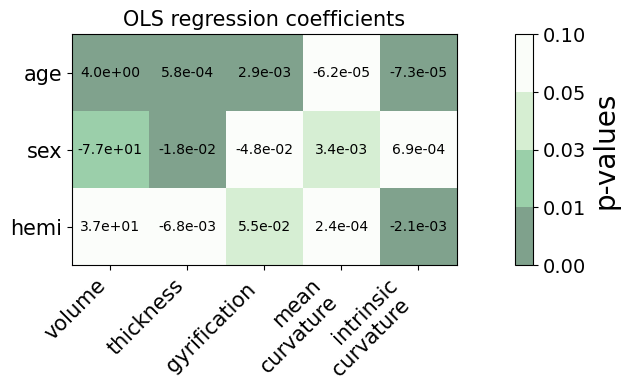

In [47]:
fig, ax = plt.subplots(figsize=(15, 3))

import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

cmap = mpl.cm.Greens_r
bounds = [0, 0.01, 0.025, 0.05, 0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
m=ax.imshow(matrix_pvals.T, cmap=cmap, norm=norm , alpha=0.5)


for (i, j), z in np.ndenumerate(matrix_coefs.T):
   ax.text(j, i, '{:.1e}'.format(z), ha='center', va='center')
ax.set_yticks([0,1,2])
ax.set_xticks(np.arange(len(sub_features)))
ax.set_yticklabels(variables, fontsize=15)
ax.set_xticklabels([return_features_title(x) for x in sub_features], fontsize=15, rotation=45, ha='right' )
ax.set_title('OLS regression coefficients', fontsize=15)
cbar = fig.colorbar(m, aspect = 13, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'p-values',fontsize=20)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format for two decimal places

plt.show()


fig.savefig(f'{OUTPUT_PATH}/matrix_covariates_combat_surfaces_noicv.png', dpi=96, transparent =True, bbox_inches = 'tight')

## 2- Compare features with values from HCP cohort

data from HCP cohort: Data previously computed from a cohort of young adults acquired at 7T from the HCP dataset, as discussed in (Jordan DeKraker et al. 2022)

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from PIL import Image
import subprocess


In [12]:
# load labels subfields
labels = cohort.subfields_labels
label_atlas = cohort.subfields_atlas
subfields_name={1:'H-Sub', 2:'H-CA1', 3:'H-CA2', 4:'H-CA3', 5:'H-CA4'}
cm = cohort.subfields_cmap

FileNotFoundError: No such file or no access: '/home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/params/templates/tmp_hemi-L_space-T1w_den-0p5mm_label-hipp_subfields.label.gii'

In [16]:
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

In [35]:
#initialise parameters

from hippunfold_toolbox import plotting

hemis = ['lh','rh']
labels = ['hipp', 'dentate']

limites = {'gyrification' : [0, 5],
             'curvature' : [-0.3, 0.4],
             'thickness' : [1.1,2],
             }

excludeDG_feats = {'gyrification' : False,
             'curvature' : False,
             'thickness' : True,}

def return_features_limites(feature):
    for feat in set(limites):
        if feat in feature:
            return limites[feat]

def return_features_excludeDG(feature):
    for feat in set(excludeDG_feats):
        if feat in feature:
            return excludeDG_feats[feat]

In [19]:
# compare smoothed features with the one computed from the HCP

path_HCP='path_to_data_HCP'
path_study='path_to_hippunfold'

file='sub-{}/surf/sub-{}_hemi-{}_space-T1w_den-0p5mm_label-{}_{}.shape.gii'

cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed.hdf5', dataset='dataset_C.csv')


hemis = ['L','R']
labels = ['hipp', 
          'dentate'
]

features = [
              'thickness',
              'curvature',
              'gyrification',
              ]

mean_controls_HCP = {}
mean_controls_study = {}
median_controls_study = {}

for feature in features:
    controls_HCP = np.array([])
    controls_study = np.array([])
    excludeDG=return_features_excludeDG(feature)
    for hemi in hemis:
        for label in labels:
            if  (label=='dentate')&(excludeDG == True):
                pass
            else:
                if label == 'dentate':
                    mask = cohort.dentate_mask
                else:
                    mask = cohort.hippo_mask    
                
                #get data from HCP
                f = nb.load(os.path.join(path_HCP,file.format('avg', 'avg', hemi, label, feature)))
                fvol = np.zeros((len(f.darrays[0].data[0]),1))
                fvol[:,0] = f.darrays[0].data[0]
                fvol[~mask,0] = 0
                controls_HCP = np.vstack((controls_HCP,fvol)) if controls_HCP.size else fvol
                

                #get data from study
                fvol = np.zeros((len(mask), len(subjects)))
                subject_included = np.zeros(len(subjects))
                for i,subject in enumerate(subjects):
                    subj = AidhsSubject(subject, cohort=cohort)
                    fvol[:,i] =  subj.load_feature_values(f'.label-{label}.{feature}.sm1', 'lh' if hemi=='L' else 'rh')
                    if fvol[:,i].sum()!=0:
                        subject_included[i]=True
                    else:
                        subject_included[i]=False
                controls_study = np.vstack((controls_study,fvol)) if controls_study.size else fvol

    mean_controls_HCP[feature] = controls_HCP[:,0]
    mean_controls_study[feature] = controls_study[:,np.array(subject_included).astype(bool)].mean(axis=1)
    median_controls_study[feature] = np.median(controls_study[:,np.array(subject_included).astype(bool)],axis=1)


/tmp/ipykernel_15366/2471629614.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_yticklabels(g.ax_joint.get_yticks().round(2), size = 20)
/tmp/ipykernel_15366/2471629614.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_xticklabels(g.ax_joint.get_xticks().round(2), size = 20)
/tmp/ipykernel_15366/2471629614.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_yticklabels(g.ax_joint.get_yticks().round(2), size = 20)
/tmp/ipykernel_15366/2471629614.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_xticklabels(g.ax_joint.get_xticks().round(2), size = 20)
/tmp/ipykernel_15366/2471629614.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_yticklabels(g.ax_joint.get_yticks().round(2), size = 20)
/tmp/ipykernel_15366/2471629614.py:63: UserWarning: FixedFor

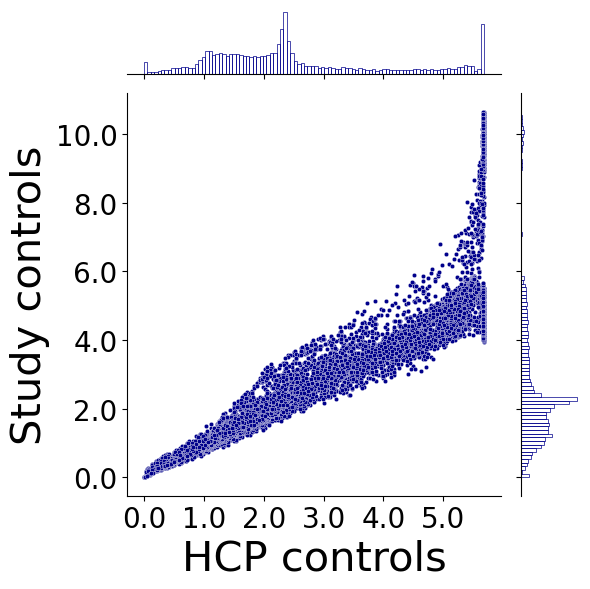

In [58]:
# plot mean controls and correlation with HCP with jointplot

from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.stats.multitest as multi
import matplotlib.image as mpimg
import matplotlib

def create_canonical_plots(data, excludeDG=False, cwindow=False, cmap=False, file='./tmp.png'):
    """plot and reload surface images"""
    fig, ax_temp = plt.subplots(nrows=1, ncols=1, figsize=(8,8), subplot_kw={'projection': "3d"})
    plotting.surfplot_canonical_foldunfold(ax_temp, data, den='0p5mm', excludeDG=excludeDG, cwindow=cwindow, cmap=cmap)
    plt.savefig(file, dpi=96, transparent =True)
    subprocess.call(f"convert {file} -trim {file}", shell=True)
    im = Image.open(file)
    im = im.convert("RGBA")
    im1 = np.array(im)
    plt.close('all')
    return im1

fig = plt.figure(figsize=(20,20), )
gs1 = gridspec.GridSpec(len(features), 2, hspace=0.2)
axs1 = []
axs2 = []

coefs=[]
pvals = []
for i,feature in enumerate(features):
    excludeDG=return_features_excludeDG(feature)
    # excludeDG = True

    if excludeDG:
        mask = np.hstack([cohort.hippo_mask ,cohort.hippo_mask])
    else:
        mask = np.hstack([cohort.dentate_mask,cohort.hippo_mask ,cohort.hippo_mask , cohort.dentate_mask])

    #data
    data1 = mean_controls_HCP[feature]
    data2 = mean_controls_study[feature]

    #plot on hippo
    axs1.append(fig.add_subplot(gs1[i,0]))
    overlay = (data2<data1.min())+(data2>data1.max())
    file = os.path.join(OUTPUT_PATH, f'controls_maps_{feature}.png') 
    cwindow=return_features_limites(feature)
    im = create_canonical_plots(data2, excludeDG=excludeDG, cwindow=cwindow, cmap=False, file=file)
    axs1[i].imshow(im)
    axs1[i].axis('off')
    axs1[i].set_title(feature, rotation='horizontal', x=-0.2,y=1, fontsize=25)

    #mask data 10% edges
    data1 = data1[mask]
    data2 = data2[mask]
    
    #plot correlation with HCP as joint plot
    df_temp = pd.DataFrame()
    df_temp['HCP controls'] = data1
    df_temp['Study controls'] = data2
    axs2.append(fig.add_subplot(gs1[i,1]))
    g = sns.jointplot(data=df_temp, x="HCP controls", y="Study controls", color='darkblue', s=10,  marginal_kws=dict(bins=100, fill=False))
    g.set_axis_labels('HCP controls', 'Study controls', fontsize=30)
    g.ax_joint.set_yticklabels(g.ax_joint.get_yticks().round(2), size = 20)
    g.ax_joint.set_xticklabels(g.ax_joint.get_xticks().round(2), size = 20)
    file = os.path.join(OUTPUT_PATH, f'controls_correlation_{feature}.png') 
    g.savefig(file)
    axs2[i].imshow(mpimg.imread(file))
    coef_p = pearsonr(data1,data2)
    coefs.append(coef_p[0])
    pvals.append(coef_p[1])
    axs2[i].axis('off')


#correct for multiple comparison
pvals_cor = multi.multipletests(pvals, alpha=0.05, method='holm')[1]

for i,feature in enumerate(features):
    if pvals_cor[i]<0.001:
        axs2[i].set_title('R={:.2f}, p<0.001'.format(coefs[i], pvals_cor[i]), fontsize=30)
    else:
        axs2[i].set_title('R={:.2f}, p={:.3f}'.format(coefs[i], pvals_cor[i]), fontsize=30)

plt.tight_layout() 
fig.savefig(os.path.join(OUTPUT_PATH, f'controls_correlation_smooth_features.png'), dpi=96, transparent =True, bbox_inches = 'tight')

thickness
curvature
gyrification


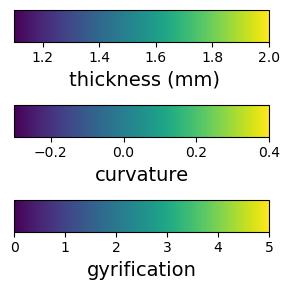

In [74]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the range of values and the colormap
cmap = 'viridis' 

labels = {'thickness':' thickness (mm)',
          'curvature': 'curvature',
          'gyrification':'gyrification'}

# Create a figure and axis for the color bar
fig, axs = plt.subplots(3,1,figsize=(3, 3))

for i, feature in enumerate(features):
    print(feature)
    cwindow = return_features_limites(feature)

    norm = plt.Normalize(vmin=cwindow[0], vmax=cwindow[1])
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), cax=axs[i],  orientation='horizontal')

    # Set the color bar label (optional)
    cbar.set_label(labels[feature], fontsize=14)
    plt.subplots_adjust(hspace=2.5)  # Adjust the hspace parameter for vertical space

# Show the color bar
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(OUTPUT_PATH, f'controls_correlation_smooth_features_colorbar.png'), dpi=96, transparent =True, bbox_inches = 'tight')
    